In [48]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

<h3>Loading data</h3>

In [50]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [51]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [52]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [53]:
num_classes = len(dataset.classes)
num_classes

6

In [54]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size , val_size

(1725, 575)

In [55]:
from torch.utils.data import random_split, DataLoader
train_dataset , val_dataset = random_split(dataset, [train_size , val_size])

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [56]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [57]:
images[0].shape

torch.Size([3, 224, 224])

In [58]:
labels[0] # this images is for coressesponding label 

tensor(2)

In [59]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


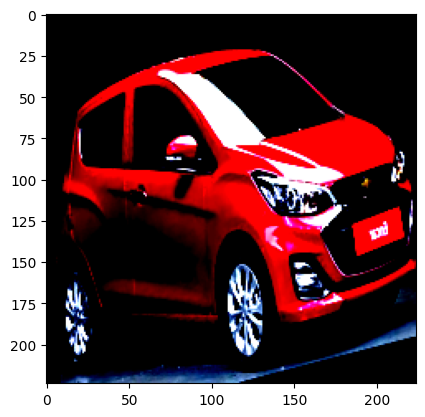

In [60]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

<h2>Model 1: CNN</h2>

In [61]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=16, kernel_size= 3, stride = 1, padding=1), #(16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0), #(16, 122, 122)
            nn.Conv2d(in_channels =16, out_channels= 32, kernel_size= 3, stride = 1, padding=1), #(16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0), #(32, 56, 56)
            nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 3, stride = 1, padding=1), #(16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0), #(64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forword(self, x):
        x = self.network(x)
        return x

In [62]:
# Instantite the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
len(train_loader.dataset)

1725

In [64]:
def train_model(model, criteria, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = image.to(device),labels.to(device)
            #Zero the parameter gradient
            optimizer.zero_grad()

            #forword pass
            outputs = model(images)
            loss = criterion(outputs,labels)

            #Backword pass and optimization
            loss.backword()
            optimizer.step()

            if(batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss +=loss.item() * images.size(0)

        epoch_loss = running_loss /len(train_loader.dataset)
        print(f"Epoch: [{epoch+1}/{epoch}], Avg Loss: {epoch_loss: .4f}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outpus = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total +=labels.size(0)
                correct += (predicted ==labels).sum().item()
                all_labels.extend(labels.cpu.numpy())

            print(f"*** Validations Accuracy: {100 *correct / total:.2f}% ***")

        end = time.time()
        print(f"Execution time: {end - start} seconds")
        
        return all_labels, all_predictions
                

In [65]:
# values, indices = torch.max(torch.tensor([[10, 12 , 15, 9]])

In [66]:
train_model(model, criterion , optimizer, epochs=1)

NameError: name 'image' is not defined